<a href="https://colab.research.google.com/github/dpostolovski/eeg_is/blob/faza2-angela/Faza2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [283]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [284]:
!pip install mne 
!pip install termcolor

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from termcolor import colored
import mne


In [285]:
# Вчитување на податоците
data = loadmat('drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainData.mat')['trainData'] 

# Вчитување на label-ите
labels_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainLabels.txt", "r") as file_labels:
    labels_arr = file_labels.read().splitlines()

# Вчитување на редоследот на светкање
events_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainEvents.txt", "r") as file_labels:
    events_arr = file_labels.read().splitlines()

# Вчитување на редоследот на објекти кои се target
targets_arr = []
with open("drive/My Drive/Интелигентни Системи/Data/SBJ01/S01-Train/trainTargets.txt", "r") as file_labels:
    targets_arr = file_labels.read().splitlines()

# Прилагодување на податоците за користење со mne библиотеката
ch_names = ["C3", "Cz", "C4", "CPz", "P3", "Pz", "P4", "POz"]
ch_types = ['eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg']
mne_info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)
mne_info.set_montage;
print(mne_info)
mne_array = np.swapaxes(data, 0, 1) # (епохa, канал, настан). 
raw_data = mne.epochs.EpochsArray(mne_array, mne_info)
if data.shape[0] == 8:
  print("Податоците се успешно вчитани.")
else:
  print("Настана грешка во вчитувањето на податоците.")

<Info | 7 non-empty values
 bads: []
 ch_names: C3, Cz, C4, CPz, P3, Pz, P4, POz
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>
350 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Податоците се успешно вчитани.


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


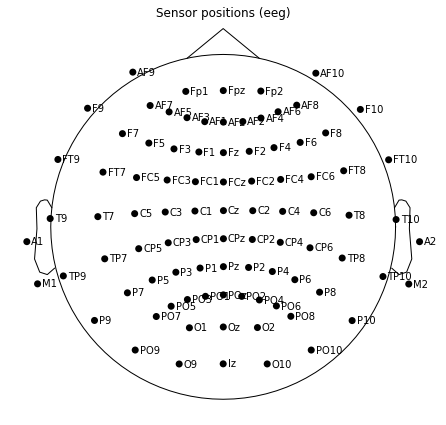

In [286]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
fig = ten_twenty_montage.plot()

Creating RawArray with float64 data, n_channels=8, n_times=1600
    Range : 0 ... 1599 =      0.000 ...     6.396 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: C3, Cz, C4, CPz, P3, Pz, P4, POz
 chs: 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>


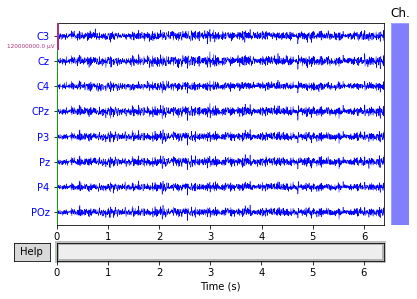

Effective window size : 6.400 (s)


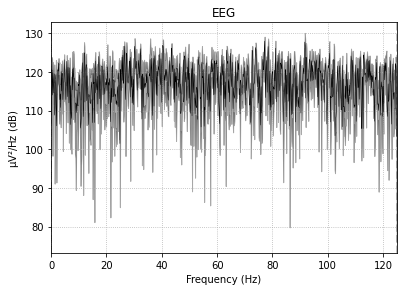

In [287]:
epoch = mne_array[175]
raw = mne.io.RawArray(epoch, mne_info)
print(raw.info)
raw.plot(n_channels=8, scalings=dict(eeg=60), title='EEG Signals',
         show=True, block=True, color = dict(eeg='blue'))
raw.plot_psd(area_mode='range', show=False, average=True);

Effective window size : 1.004 (s)


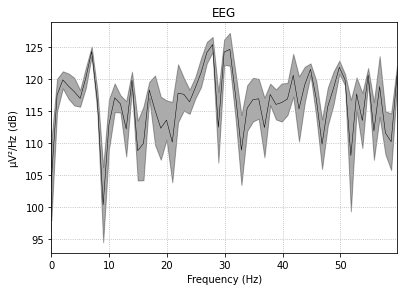

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 8 components
Fitting ICA took 0.1s.


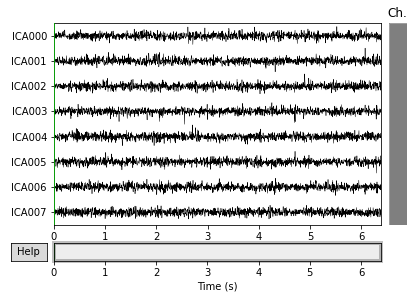

In [288]:
from mne.preprocessing import ICA
raw.plot_psd(tmin=0.2, tmax=1.2, fmin=0, fmax=60, average=True, spatial_colors=False);
num_components = 8
ica = ICA(n_components=num_components, method='fastica')
ica.fit(raw)
ica.plot_sources(raw);

350 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 350 events and 276 original time points ...
25 bad epochs dropped
<Epochs  |   325 events (all good), -0.1 - 1 sec, baseline [None, 0], ~5.5 MB, data loaded,
 '1': 325>
Original sampling rate: 250.0 Hz
New sampling rate: 175.0 Hz


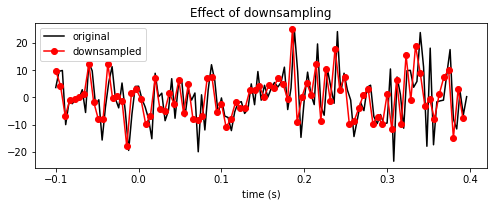

In [299]:
events = raw_data.events
epochs = mne.Epochs(raw, events, tmin=-0.1, tmax=1, preload=True)
print(epochs)
# Downsample to 175 Hz
print('Original sampling rate:', epochs.info['sfreq'], 'Hz')
epochs_resampled = epochs.copy().resample(175, npad='auto')
print('New sampling rate:', epochs_resampled.info['sfreq'], 'Hz')

# Plot a piece of data to see the effects of downsampling
plt.figure(figsize=(7, 3))

n_samples_to_plot = int(0.5 * epochs.info['sfreq'])  # plot 0.5 seconds of data
plt.plot(epochs.times[:n_samples_to_plot],
         epochs.get_data()[ 0, 0, :n_samples_to_plot], color='black')

n_samples_to_plot = int(0.5 * epochs_resampled.info['sfreq'])
plt.plot(epochs_resampled.times[:n_samples_to_plot],
         epochs_resampled.get_data()[ 0, 0, :n_samples_to_plot],
         '-o', color='red')

plt.xlabel('time (s)')
plt.legend(['original', 'downsampled'], loc='best')
plt.title('Effect of downsampling')
mne.viz.tight_layout()

In [300]:
print(len(raw_data.events))
print(len(epochs_resampled.events))

350
325
